In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Question 2. Matrix Factorization with Regularization (33 points)

There is a user-item matrix, M available where nonzero elements of the matrix are ratings that a user has
for an item. The objective of matrix factorization is to learn a low-rank factorization of M. It decomposes
a large matrix into products of matrices, namely, M = U × V


## 1.)
In order to learn matrix U and V, we will minimize following loss function L. In order to overcome
the problem of overfitting, we are going to use matrix factorization with regularization for this
problem. We define the loss function L as follows:

\begin{equation}
L = \sum_{i,j} (M_{i,j} - U_iV_j^T)^2 + \lambda (\sum_i ||U_i||^2 + \sum_j ||V_j||^2)\ \ \ \ \ \text{(1)}
\end{equation}


Use the Alternating Least Squares method to minimize the loss function to learn matrix U and V
(Hint: fix U or V one at a time, derive a closed form solution for the other). Write out pseudocode
for implementing the algorithm. You should clearly show the closed form solution in the updating
step of your pseudocode. 

#### **ANSWER**
Noting from (1) above that $M_{i,j} , U_i, V_j$ are indicative of the $i^{th} and j^{th}$ elements of matrices M,U,V we can rewrite (1) in a vectorized format so as to remove the need for a **for** loop

\begin{equation}
L = (M - UV^T)^2 + \lambda (||U||^2 + ||V||^2)\ \ \ \ \ \text{(2)}
\end{equation}

Where $U = ℝ^{rank\ x\ i}$ and $V = ℝ^{rank\ x\ j}$ and i,j are reflective of $M_{i,j}$ 

Since L is a function of U and V, this objective is non-convex. Note however, that if we fix the set of Variables V and treat them as constants, then the objective is a convex function of U and vice versa

Holding V constant and taking the deriviative of (2) with respect to U yields:

\begin{equation}
\frac{\partial}{\partial U} L \\ 
= 2(M - UV^T)V + 2 \lambda U \\
= 2VM^T - 2UVV^T + 2 \lambda U\ \ \ \ \ \text{(3)}
\end{equation}

Dividing (3) by 2, setting it equal to 0 and solving for U yields:

\begin{equation}
VM^T - UVV^T + \lambda U = 0\\
UVV^T + \lambda U = VM^T \\
U (VV^T + \lambda I) = VM^T \\ 
U = (VV^T + \lambda I)^{-1}VM^T\ \ \ \ \text{(4)}
\end{equation}

Since the derivation is exactly the same when holding U constant and solving for V, we arrive at 

\begin{equation}
V = (UU^T + \lambda I)^{-1}UM\ \ \ \ \ \text{(5)}
\end{equation}

Notice (4) ends with $VM^T$ and (5) ends with $UM$. This is because M is an (i x j) matrix, U is a (rank x i) matrix, and V is a (rank x j) matrix. Therefor M must be transposed when dotted with V to line up dimensions.


#### <u>Algorithm <u>

**inputs**: M, rank, lambda, iterations <br>
**outpus**: U, V <br><br>
i,j = shape(M) <br>
Initialize U $\in random(ℝ^{rank\ x\ i})$<br>
for iter = 1, 2, ... iterations: **do**<br>
$\ \ \ \ \ V := (UU^T + \lambda I)^{-1}UM$ <br>
$\ \ \ \ \ U := (VV^T + \lambda I)^{-1}VM^T$ <br>
**end**
    
return U,V

## 2.)
Implement your proposed algorithm using the data located in the the folder ratings.data from
MoviesLens Dataset. This dataset consists of ratings of 1682 movies by 943 users (on a 1-5 scale).
The test.csv file is generated by removing 10 of the item ratings from train.csv for each user and
assign them to test dataset. Plot both training and test errors in terms of MSE versus number of
iterations. Please use rank d =20, lambda =0.01 and train it for 100 iterations.

In [2]:
train = pd.read_csv('Q2_train.csv', header=None)
test = pd.read_csv('Q2_test.csv', header=None)

In [3]:
#dimensions = users x ratings
print('{} users ; {} ratings'.format(*train.shape))
train.head()


943 users ; 1682 ratings


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,4.0,3.0,3.0,5.0,0.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def als(M, test, d, lam, iters):
    #intialize U
    #shape should be rank x M[rows]
    U = np.random.random((d, M.shape[0]))
    
    #storage for errors per iteration
    train_errors = []
    test_errors = []
    
    #mask for non-zero elements
    mask_train = ~(M == 0)
    mask_test = ~(test == 0)
    
    #iterate
    for _ in range(iters):
        
        #hold U constant and update V
        V = np.linalg.pinv(U.dot(U.T) + lam * np.eye(d)).dot(U.dot(M))
 
        #hold V constant and update U
        U = np.linalg.pinv(V.dot(V.T) + lam * np.eye(d)).dot(V.dot(M.T))
    
        #reconstruct matrix from factors
        reconstructed = U.T.dot(V)
        
        #compute reconstruction error
        train_error = mean_squared_error(M[mask_train], reconstructed[mask_train])
        test_error = mean_squared_error(test[mask_test], reconstructed[mask_test])
        
        #append errors
        train_errors.append(train_error)
        test_errors.append(test_error)
        
    return train_errors, test_errors

In [5]:
def plotit(train, test):
    plt.figure(figsize=(20,10))
    plt.plot(range(len(train)), train, color='yellow', lw=3,label='Train MSE', path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
    plt.plot(range(len(test)), test, color='green', lw=3, label='Test MSE', path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.title('ALS Error per Iterations')
    plt.legend()
    plt.show()

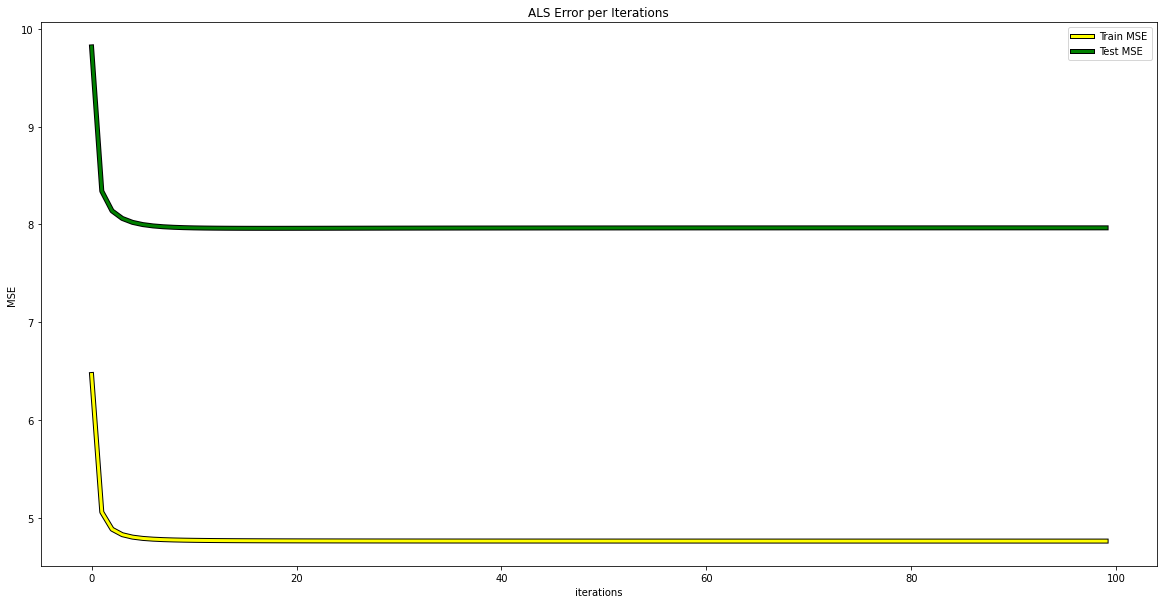

In [6]:
plotit(*als(M=train.values,test=test.values, d=20, lam=0.01, iters=100))